## Developing the perceptron algorithm 

## step-1 Data Loading and Initial Exploration

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose

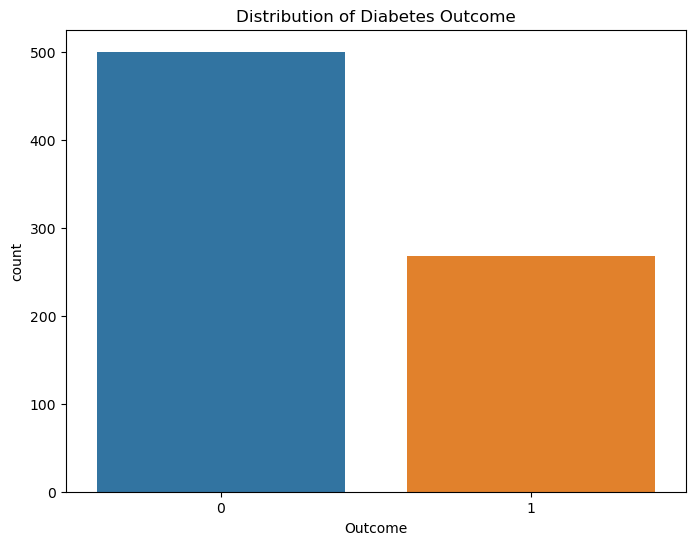

<Figure size 1500x1000 with 0 Axes>

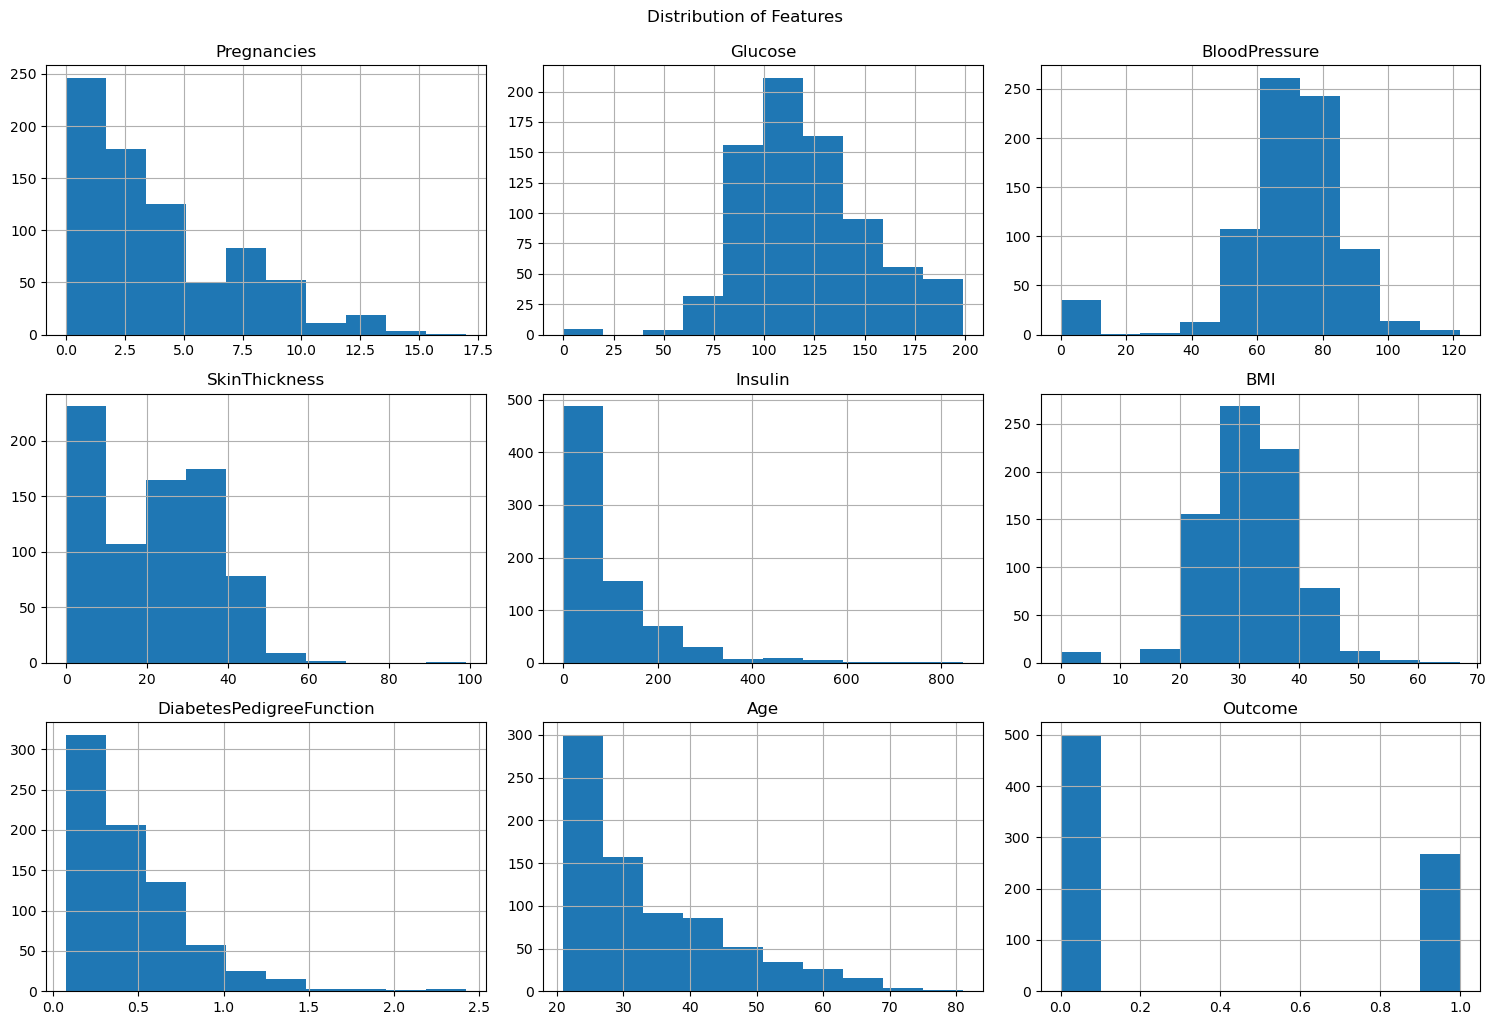

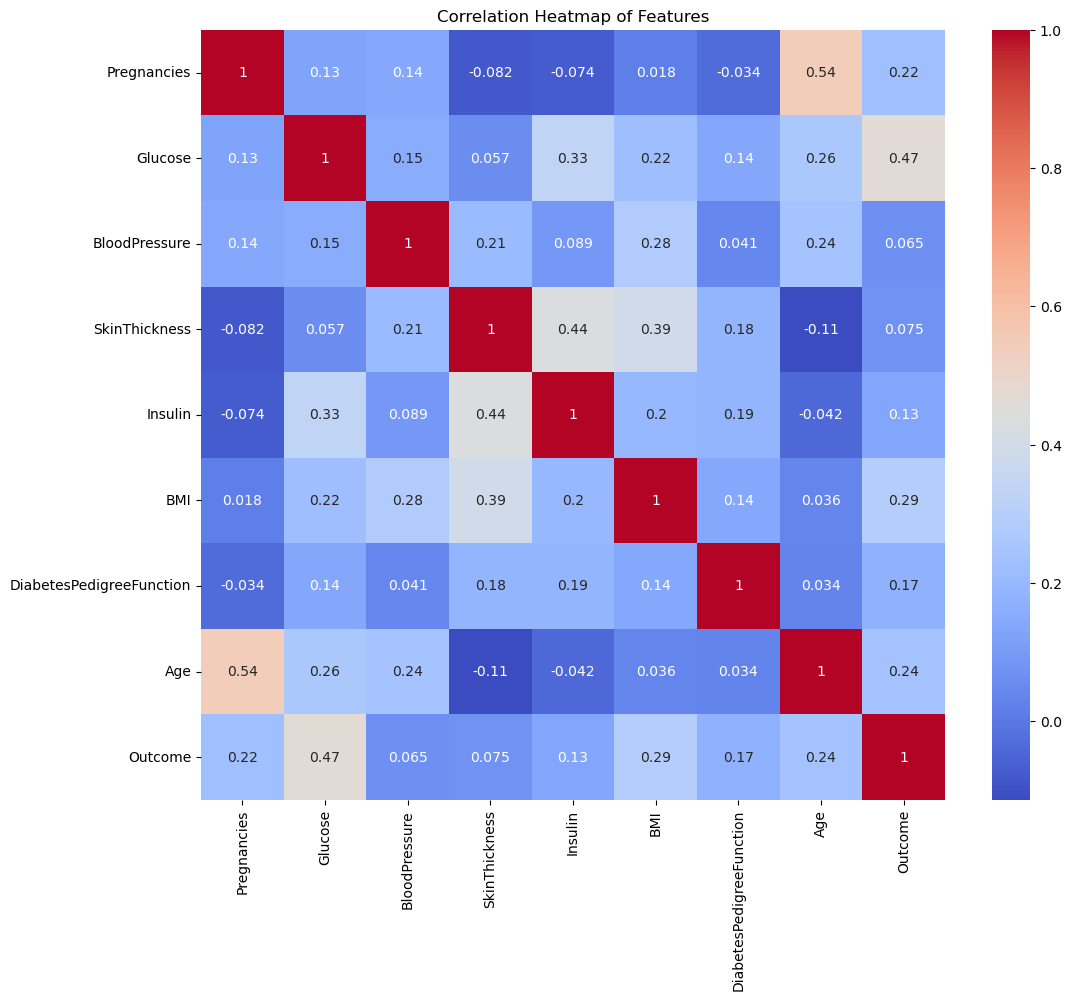

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('C:Downloads\diabetes.csv')

# Displayed first few rows and basic information
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

# Checked for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Separated features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns.tolist())
print("Target variable:", y.name)


# Visualized the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=data)
plt.title('Distribution of Diabetes Outcome')
plt.show()

# Visualized the distribution of features
plt.figure(figsize=(15, 10))
data.hist(figsize=(15, 10))
plt.tight_layout()
plt.suptitle('Distribution of Features', y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

## Step-2 Pre-processing the data

Training set shape: (736, 10)
Testing set shape: (184, 10)


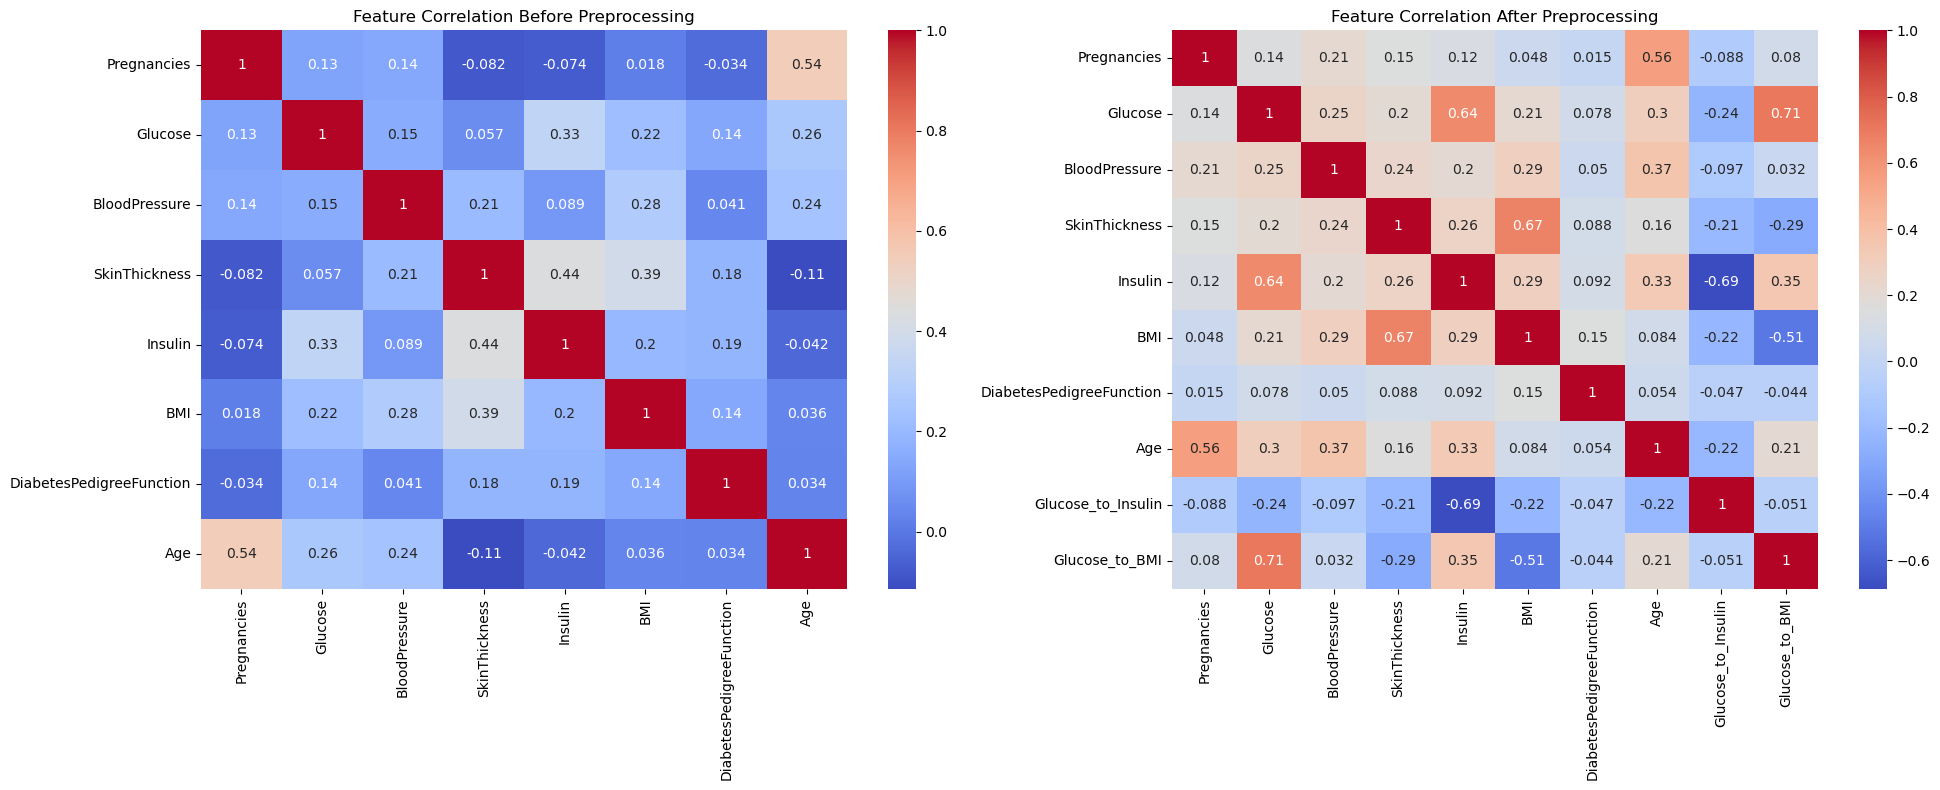

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Loaded the data
data = pd.read_csv('C:Downloads\diabetes.csv')
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Handled missing values (replace 0 with NaN for certain columns)
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
X_with_nan = X.copy()
X_with_nan[columns_to_impute] = X_with_nan[columns_to_impute].replace(0, np.nan)

# Imputed missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_with_nan), columns=X.columns)

# Function to remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Removed outliers
X_no_outliers = remove_outliers(X_imputed)
y_no_outliers = y.loc[X_no_outliers.index]

# Featured engineering (create new features safely)
X_no_outliers = X_no_outliers.copy()  # Explicit copy to avoid SettingWithCopyWarning
X_no_outliers['Glucose_to_Insulin'] = X_no_outliers['Glucose'] / (X_no_outliers['Insulin'].replace(0, np.nan) + 1)
X_no_outliers['BMI_to_Age'] = X_no_outliers['BMI'] / (X_no_outliers['Age'].replace(0, np.nan) + 1)
X_no_outliers['Glucose_to_BMI'] = X_no_outliers['Glucose'] / (X_no_outliers['BMI'].replace(0, np.nan) + 1)

# Replaced inf and -inf values with NaN
X_no_outliers.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputed again after feature engineering
X_no_outliers = pd.DataFrame(imputer.fit_transform(X_no_outliers), columns=X_no_outliers.columns)

# Selected top 10 features using SelectKBest
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_no_outliers, y_no_outliers)
X_no_outliers = pd.DataFrame(X_selected, columns=X_no_outliers.columns[selector.get_support()])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_no_outliers, y_no_outliers)

# Splited the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Printed shape of processed data
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Visualized the correlation between features before and after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Correlation heatmap before preprocessing
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Feature Correlation Before Preprocessing')

# Correlation heatmap after preprocessing
sns.heatmap(X_no_outliers.corr(), annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Feature Correlation After Preprocessing')

plt.tight_layout()
plt.show()

## Step-3  Implement Perceptron Algorithm


In [81]:
import numpy as np
import pandas as pd

class Perceptron:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.errors_ = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Converted to numpy array if input is pandas DataFrame or Series
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y

        for _ in range(self.n_iterations):
            errors = 0
            for idx in range(n_samples):
                x_i = X[idx]
                y_i = y[idx]
                
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = 1 if linear_output >= 0 else 0
                
                update = self.learning_rate * (y_i - y_predicted)
                self.weights += update * x_i
                self.bias += update
                errors += int(update != 0.0)
            self.errors_.append(errors)

    def predict(self, X):
        # Convert to numpy array if input is pandas DataFrame
        X = X.values if isinstance(X, pd.DataFrame) else X
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, 0)
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [82]:
# Initialized and train the Perceptron
perceptron = Perceptron(learning_rate=0.01, n_iterations=1000)
perceptron.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = perceptron.predict(X_train_scaled)
y_pred_test = perceptron.predict(X_test_scaled)

# Calculated accuracy
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Accuracy: 0.7133
Testing Accuracy: 0.6902
Precision: 0.6486
Recall: 0.8000
F1-score: 0.7164


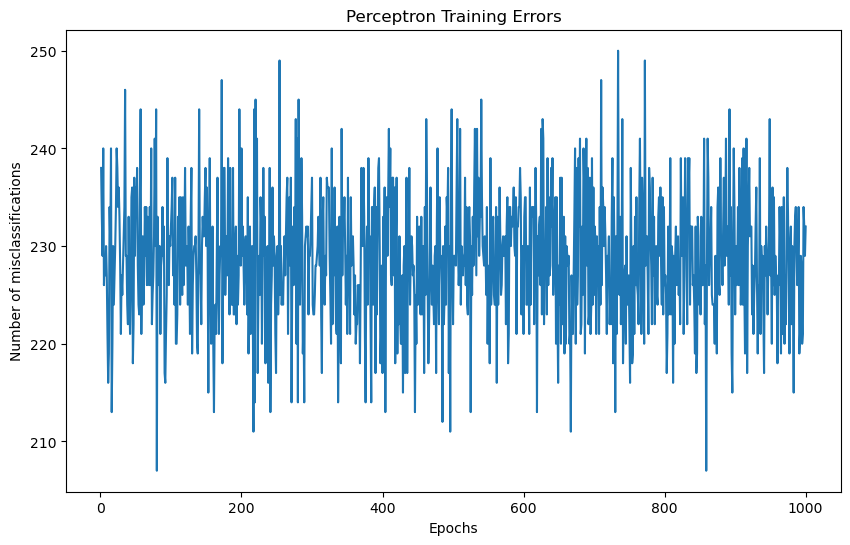

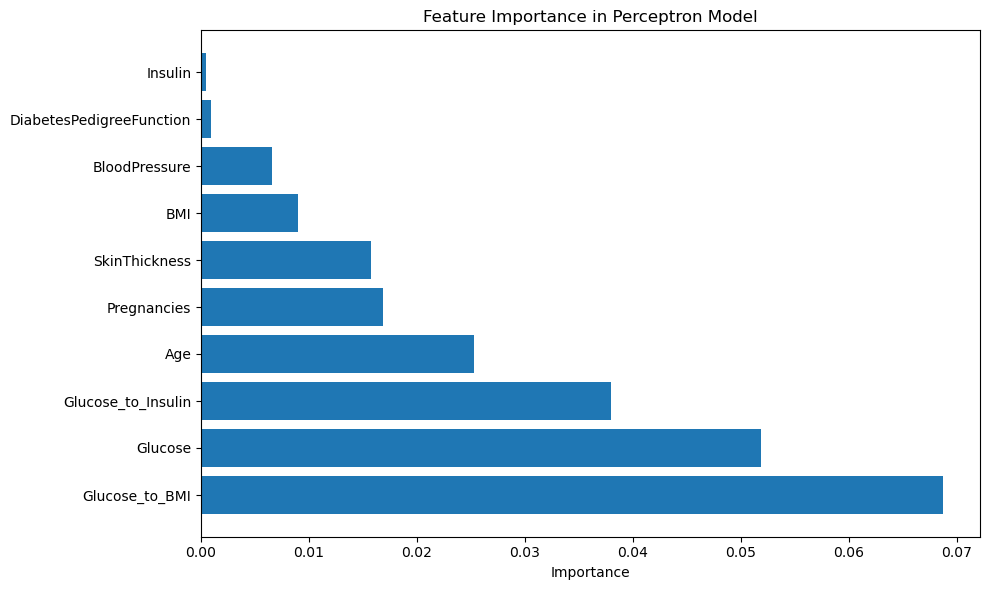

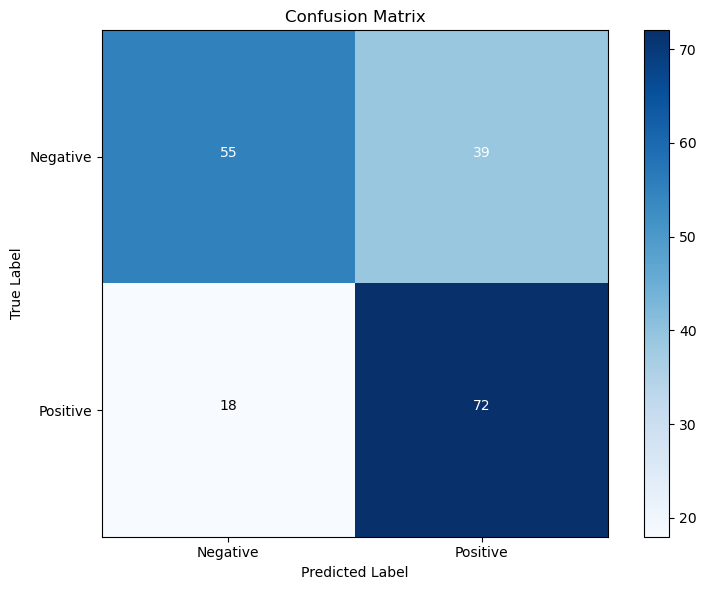

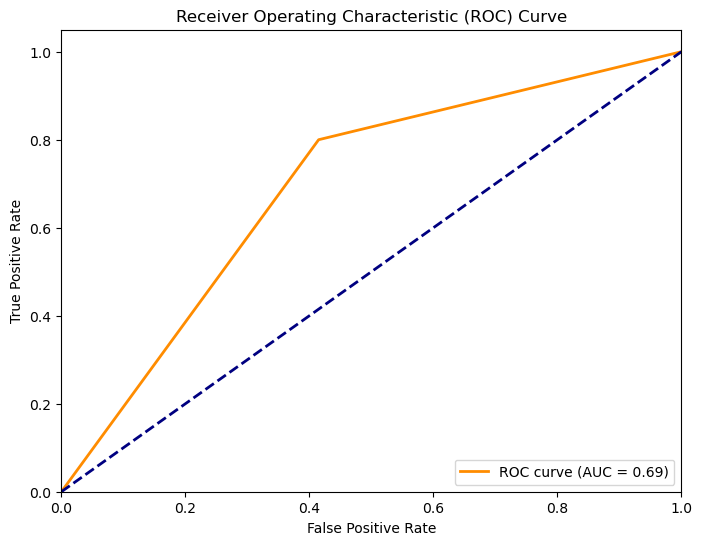

In [83]:
# Visualized training errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(perceptron.errors_) + 1), perceptron.errors_)
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.title('Perceptron Training Errors')
plt.show()

# Visualized feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': np.abs(perceptron.weights)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Perceptron Model')
plt.tight_layout()
plt.show()

# Ploted confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Added text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Plotted ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## experimental analysis and testing

In [84]:
import numpy as np

class Perceptron:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.errors_ = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            errors = 0
            for idx, (x_i, y_i) in enumerate(zip(X, y)):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = 1 if linear_output >= 0 else 0
                
                update = self.learning_rate * (y_i - y_predicted)
                self.weights += update * x_i
                self.bias += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, 0)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "n_iterations": self.n_iterations}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


Model Comparison:
------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-score  
------------------------------------------------------------
Perceptron           0.6902     0.6486     0.8000     0.7164    
Logistic Regression  0.7826     0.7660     0.8000     0.7826    
Decision Tree        0.7717     0.7353     0.8333     0.7812    
Random Forest        0.8098     0.7619     0.8889     0.8205    
SVM                  0.8098     0.7723     0.8667     0.8168    
KNN                  0.7500     0.7075     0.8333     0.7653    


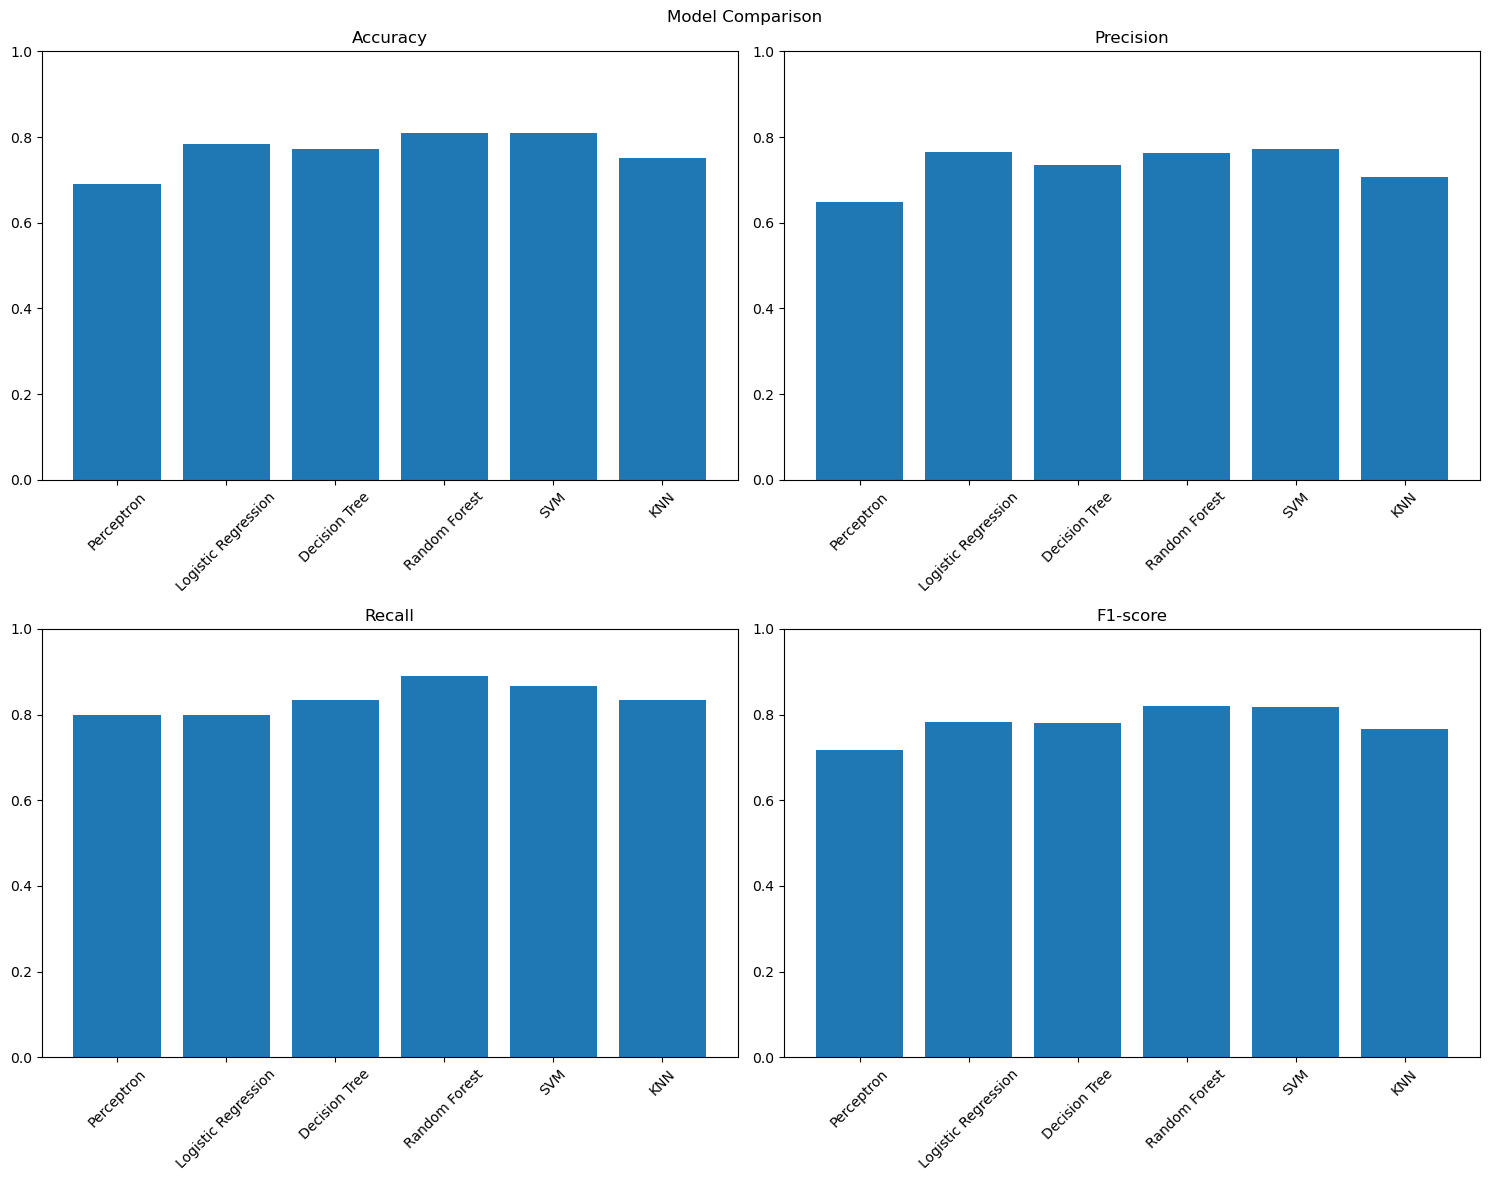


Cross-validation Results:
------------------------------------------------------------
Model                Mean       Std       
------------------------------------------------------------
Perceptron           0.6821     0.0500    
Logistic Regression  0.7676     0.0208    
Decision Tree        0.7514     0.0235    
Random Forest        0.8370     0.0129    
SVM                  0.8043     0.0306    
KNN                  0.7663     0.0212    


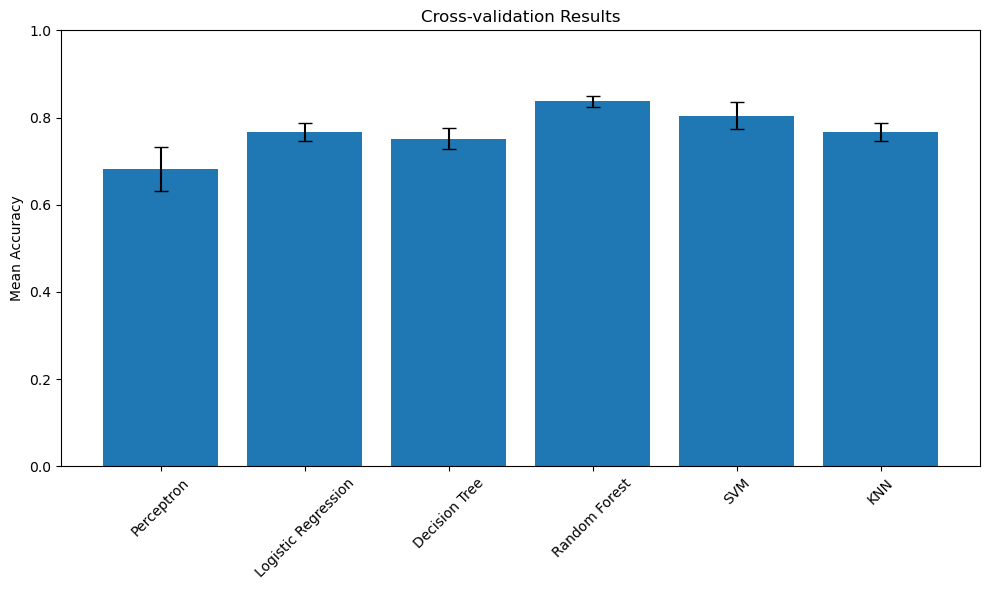

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are already defined

# Define models
models = {
    'Perceptron': Perceptron(learning_rate=0.01, n_iterations=1000),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred)
    }

# Print results
print("\nModel Comparison:")
print("------------------------------------------------------------")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1-score"))
print("------------------------------------------------------------")
for model, metrics in results.items():
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        model, metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1-score']))

# Visualize results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison')

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    values = [results[model][metric] for model in models]
    ax.bar(models.keys(), values)
    ax.set_title(metric)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Perform cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = {
        'Mean': scores.mean(),
        'Std': scores.std()
    }

print("\nCross-validation Results:")
print("------------------------------------------------------------")
print("{:<20} {:<10} {:<10}".format("Model", "Mean", "Std"))
print("------------------------------------------------------------")
for model, metrics in cv_results.items():
    print("{:<20} {:<10.4f} {:<10.4f}".format(model, metrics['Mean'], metrics['Std']))

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
means = [metrics['Mean'] for metrics in cv_results.values()]
stds = [metrics['Std'] for metrics in cv_results.values()]
plt.bar(models.keys(), means, yerr=stds, capsize=5)
plt.title('Cross-validation Results')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## It is very hard to Get high accuracy using Perceptron Model So I have impletemented the Multi-layer Perceptron

## Step-1 Loading the from Dataset

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose

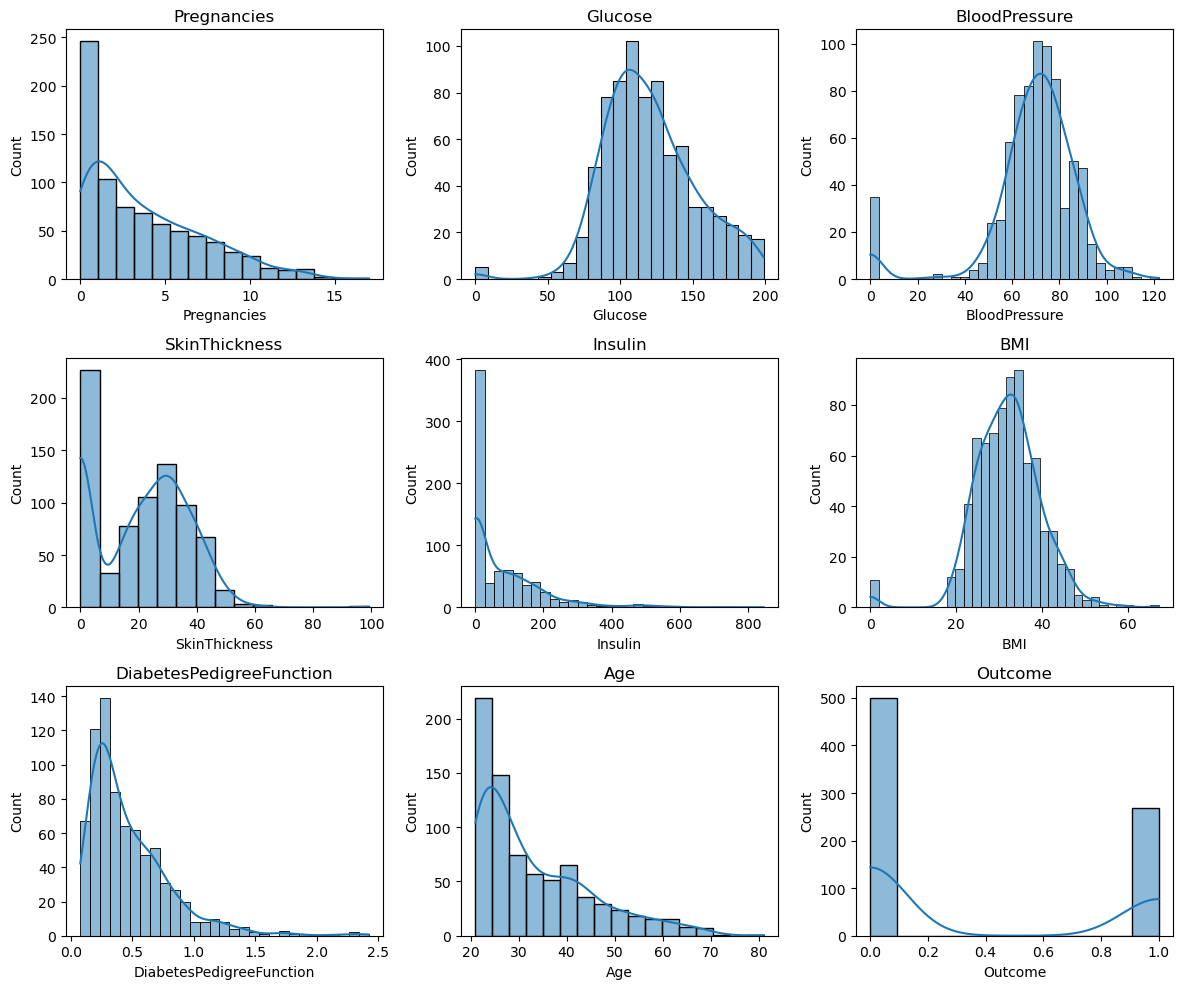

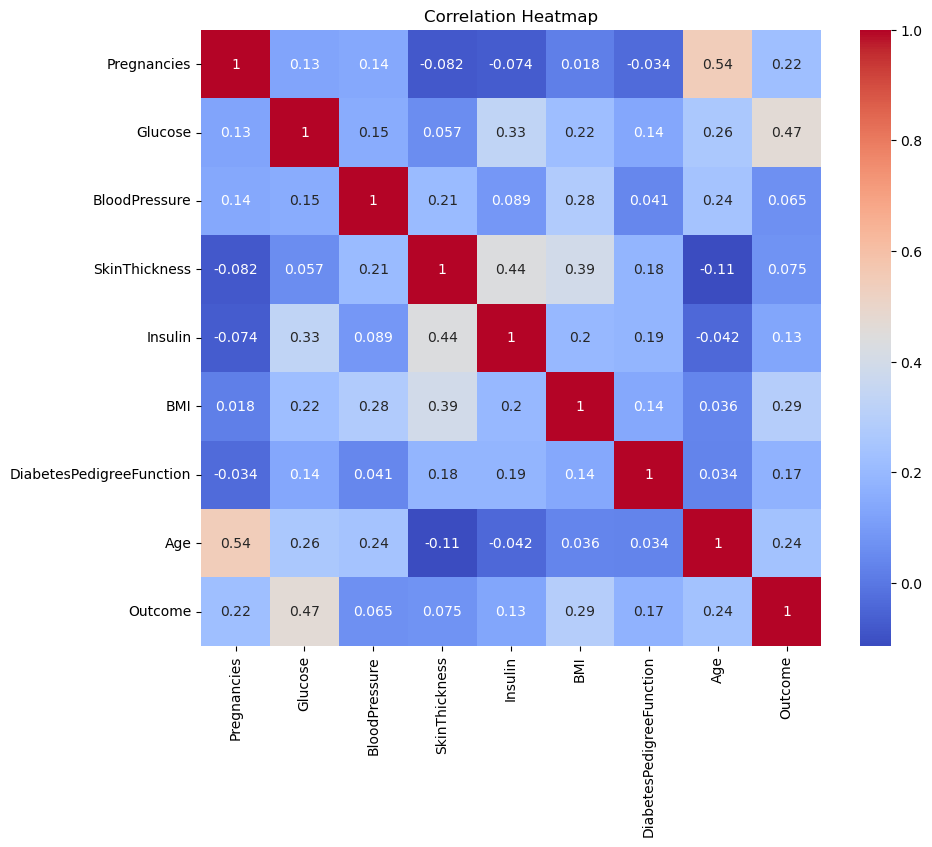

In [86]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv("C:Downloads\diabetes.csv")

# Displayed first few rows and basic information
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

# Checked for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Visualized distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
for i, column in enumerate(data.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Step-2 Pre-processing the Data

Missing values after replacing zeros:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Shape before removing outliers: (768, 8)
Shape after removing outliers: (515, 8)


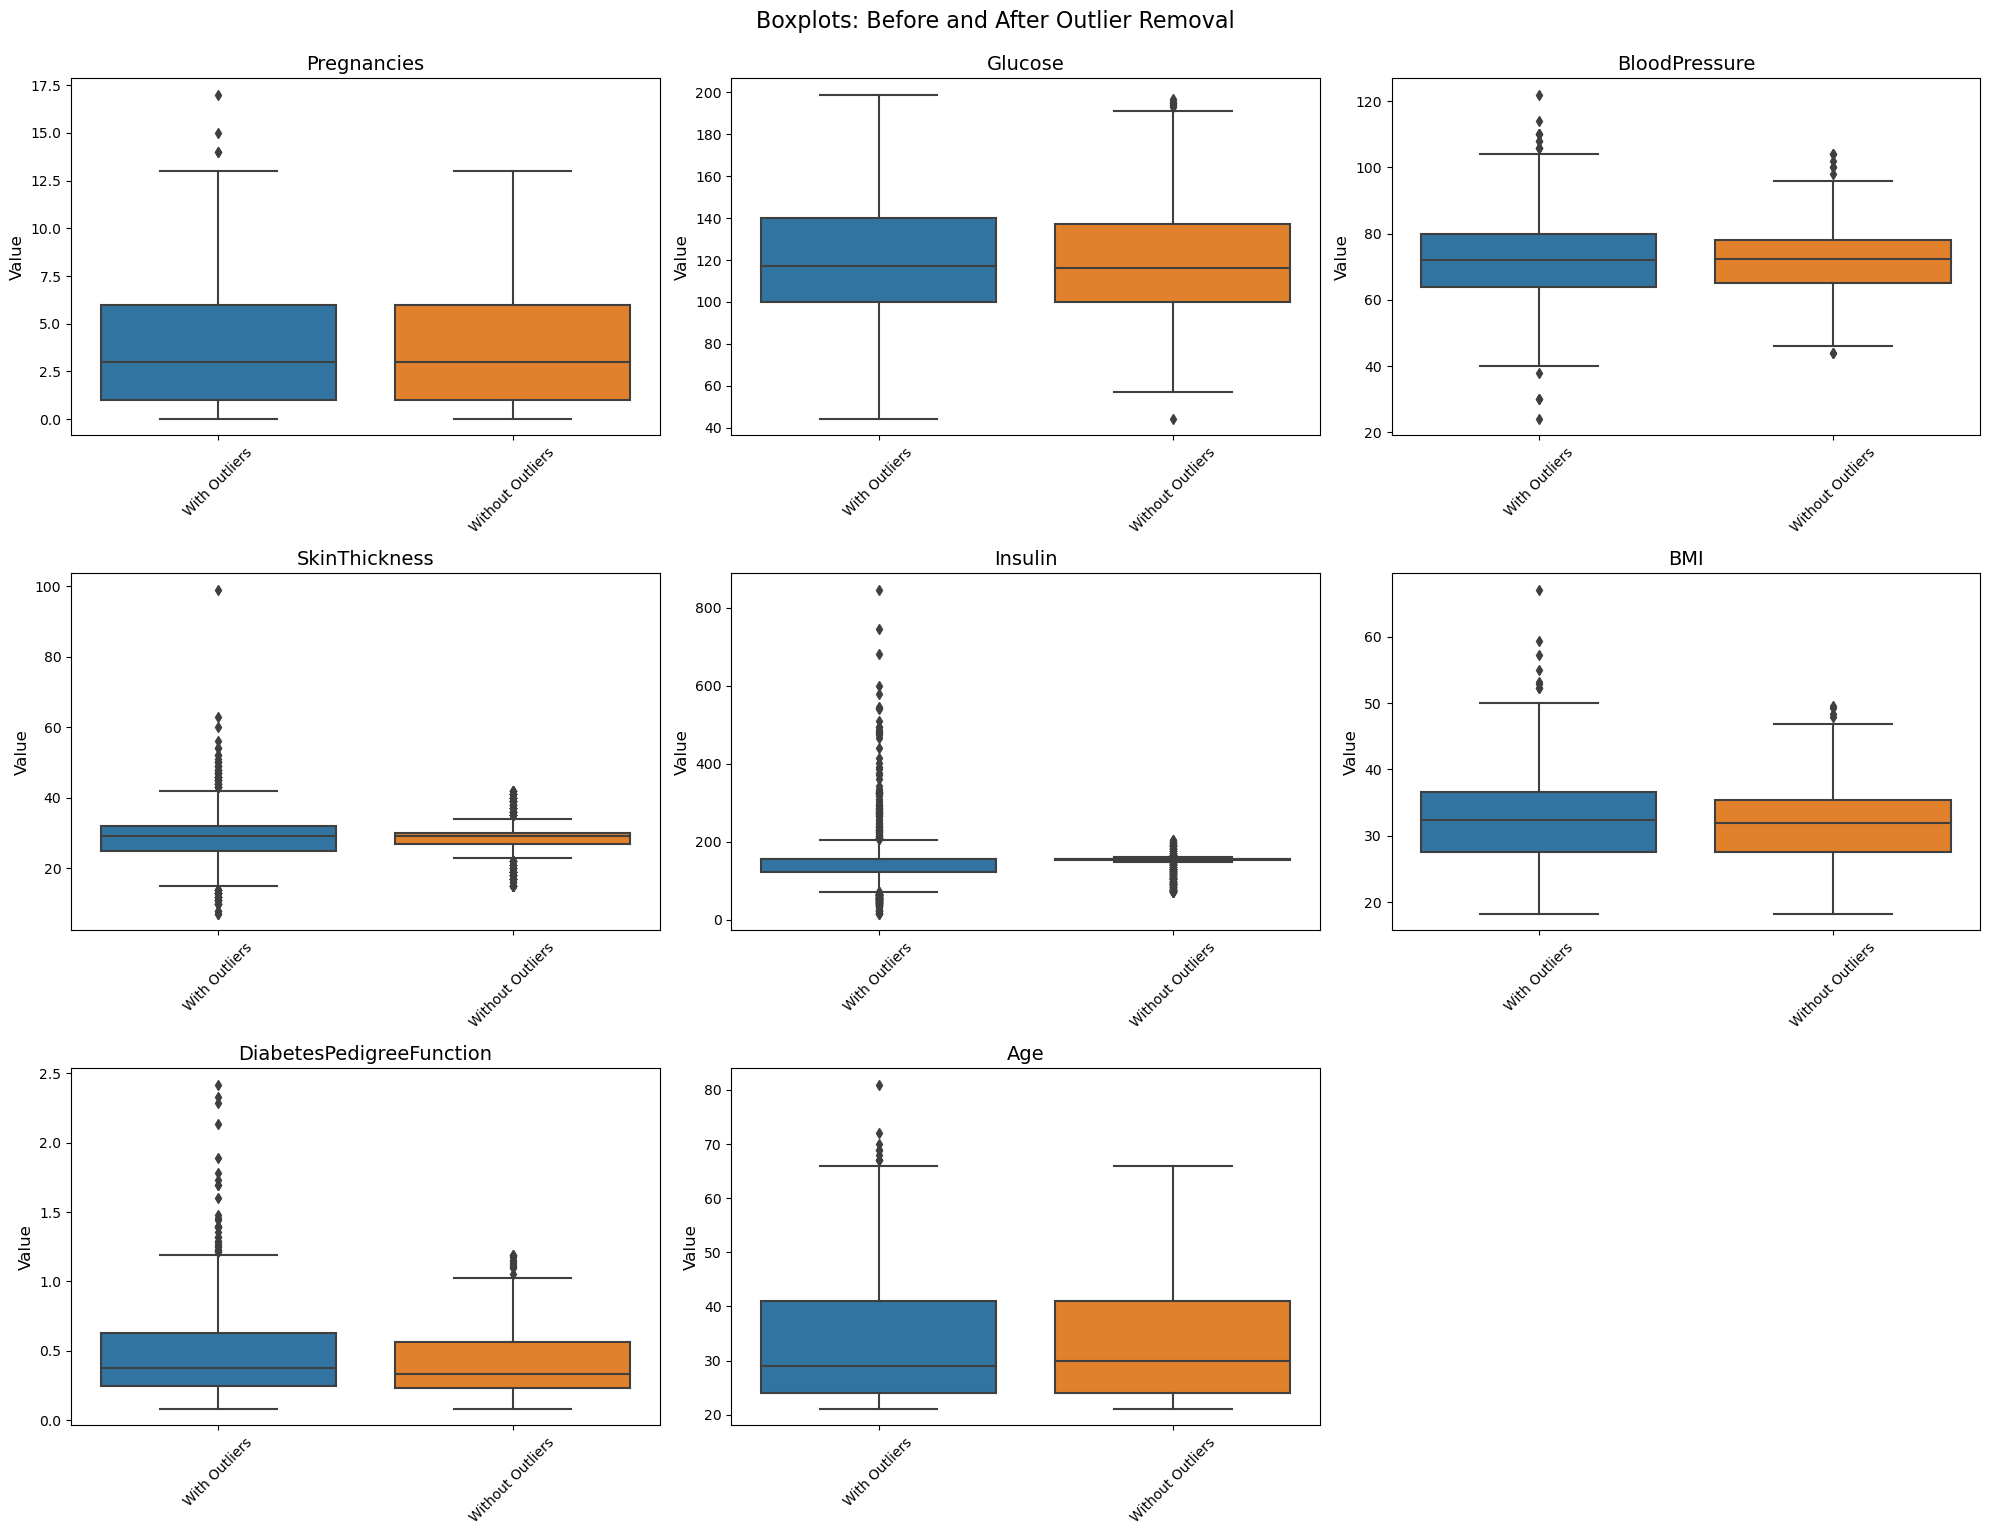

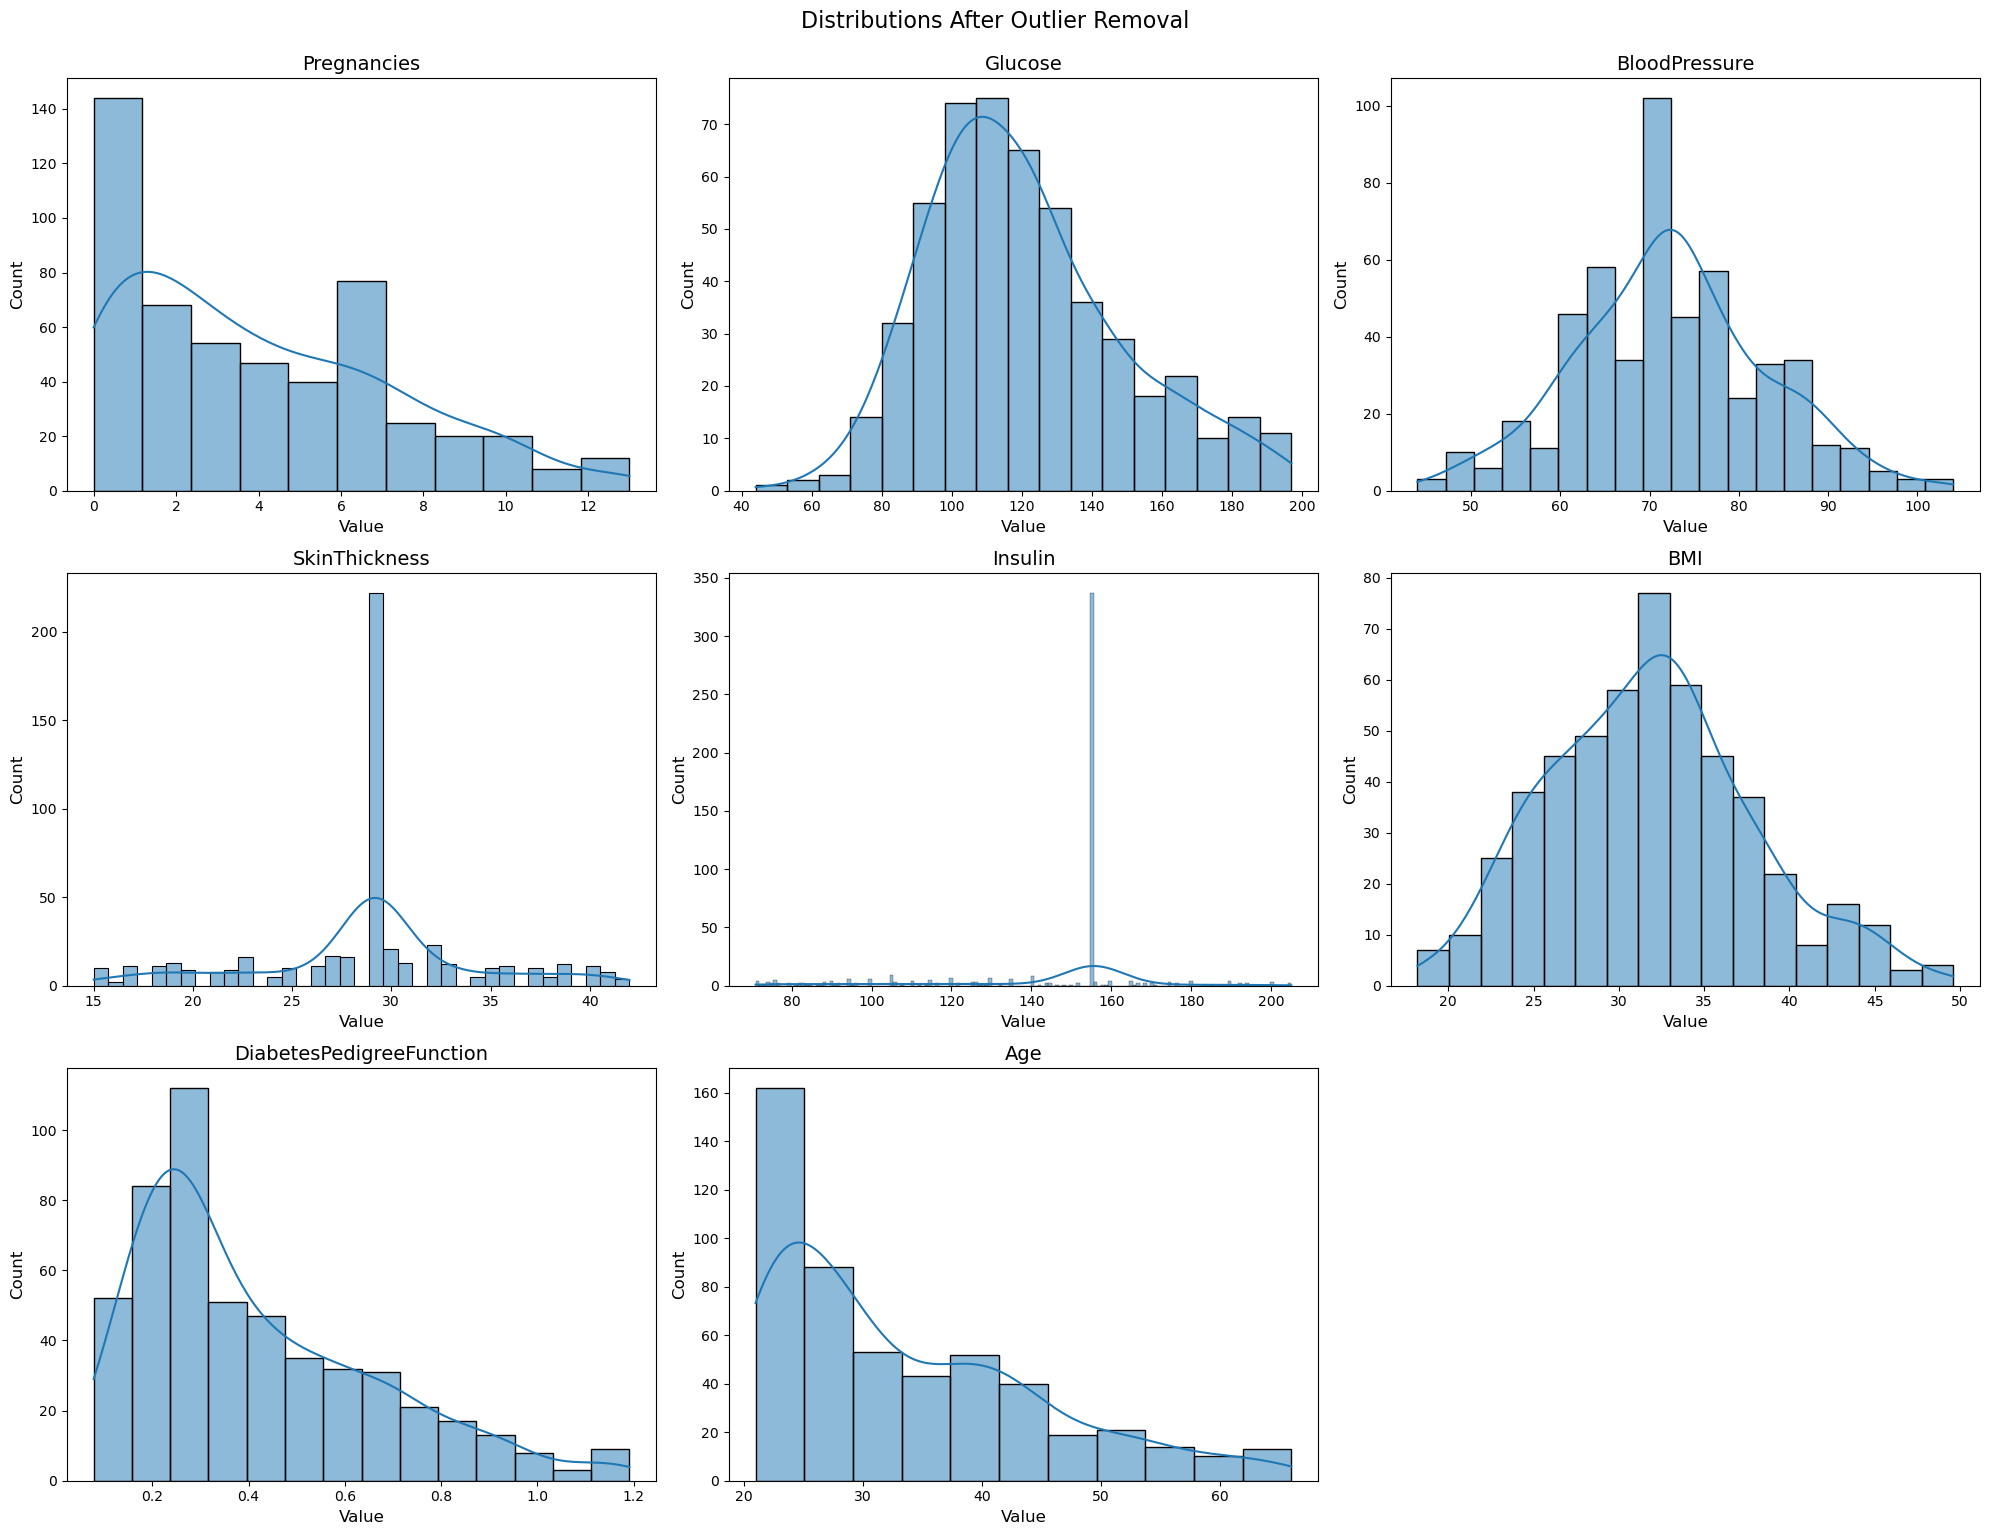

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv("C:Downloads\diabetes.csv")

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Function to remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Handle missing values (replace 0 with NaN for certain columns)
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
X[columns_to_impute] = X[columns_to_impute].replace(0, np.nan)

print("Missing values after replacing zeros:")
print(X.isnull().sum())

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("\nMissing values after imputation:")
print(X_imputed.isnull().sum())

# Remove outliers
X_no_outliers = remove_outliers(X_imputed)
y_no_outliers = y[X_no_outliers.index]

print(f"\nShape before removing outliers: {X_imputed.shape}")
print(f"Shape after removing outliers: {X_no_outliers.shape}")

# Visualize before and after outlier removal
plt.figure(figsize=(20, 15))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=[X_imputed[column], X_no_outliers[column]])
    plt.title(column, fontsize=14)
    plt.xticks([0, 1], ['With Outliers', 'Without Outliers'], rotation=45)
    plt.ylabel('Value', fontsize=12)
plt.tight_layout()
plt.suptitle('Boxplots: Before and After Outlier Removal', fontsize=16, y=1.02)
plt.show()

# Visualize distributions after outlier removal
plt.figure(figsize=(20, 15))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_no_outliers[column], kde=True)
    plt.title(column, fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.suptitle('Distributions After Outlier Removal', fontsize=16, y=1.02)
plt.show()

# Update X and y for further processing
X = X_no_outliers
y = y_no_outliers

## step 3 Split the Data and Scale Features

In [88]:
# Remove outliers
X_no_outliers = remove_outliers(X_imputed)
y_no_outliers = y[X_no_outliers.index]

print(f"\nShape before removing outliers: {X_imputed.shape}")
print(f"Shape after removing outliers: {X_no_outliers.shape}")
print(f"Shape of y after removing outliers: {y_no_outliers.shape}")

# Update X and y for further processing
X = X_no_outliers
y = y_no_outliers


Shape before removing outliers: (768, 8)
Shape after removing outliers: (515, 8)
Shape of y after removing outliers: (515,)


Training set shape: (412, 8)
Testing set shape: (103, 8)

Scaled data summary:
        Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  4.120000e+02  4.120000e+02   4.120000e+02   4.120000e+02  4.120000e+02   
mean   8.623091e-18 -4.699585e-16   6.639780e-16   8.579976e-16 -1.155494e-15   
std    1.001216e+00  1.001216e+00   1.001216e+00   1.001216e+00  1.001216e+00   
min   -1.233916e+00 -2.680706e+00  -2.689601e+00  -2.447887e+00 -2.875103e+00   
25%   -9.298652e-01 -7.025902e-01  -6.197248e-01  -1.576249e-01  9.280264e-02   
50%   -3.217629e-01 -1.727377e-01  -5.652726e-03   4.557766e-02  4.050427e-01   
75%    5.903906e-01  6.043794e-01   5.460676e-01   2.387666e-01  4.050427e-01   
max    2.718749e+00  2.723789e+00   3.020403e+00   2.308811e+00  2.323581e+00   

                BMI  DiabetesPedigreeFunction           Age  
count  4.120000e+02              4.120000e+02  4.120000e+02  
mean   2.586927e-16             -2.716274e-16 -1.293464e-17  
std  

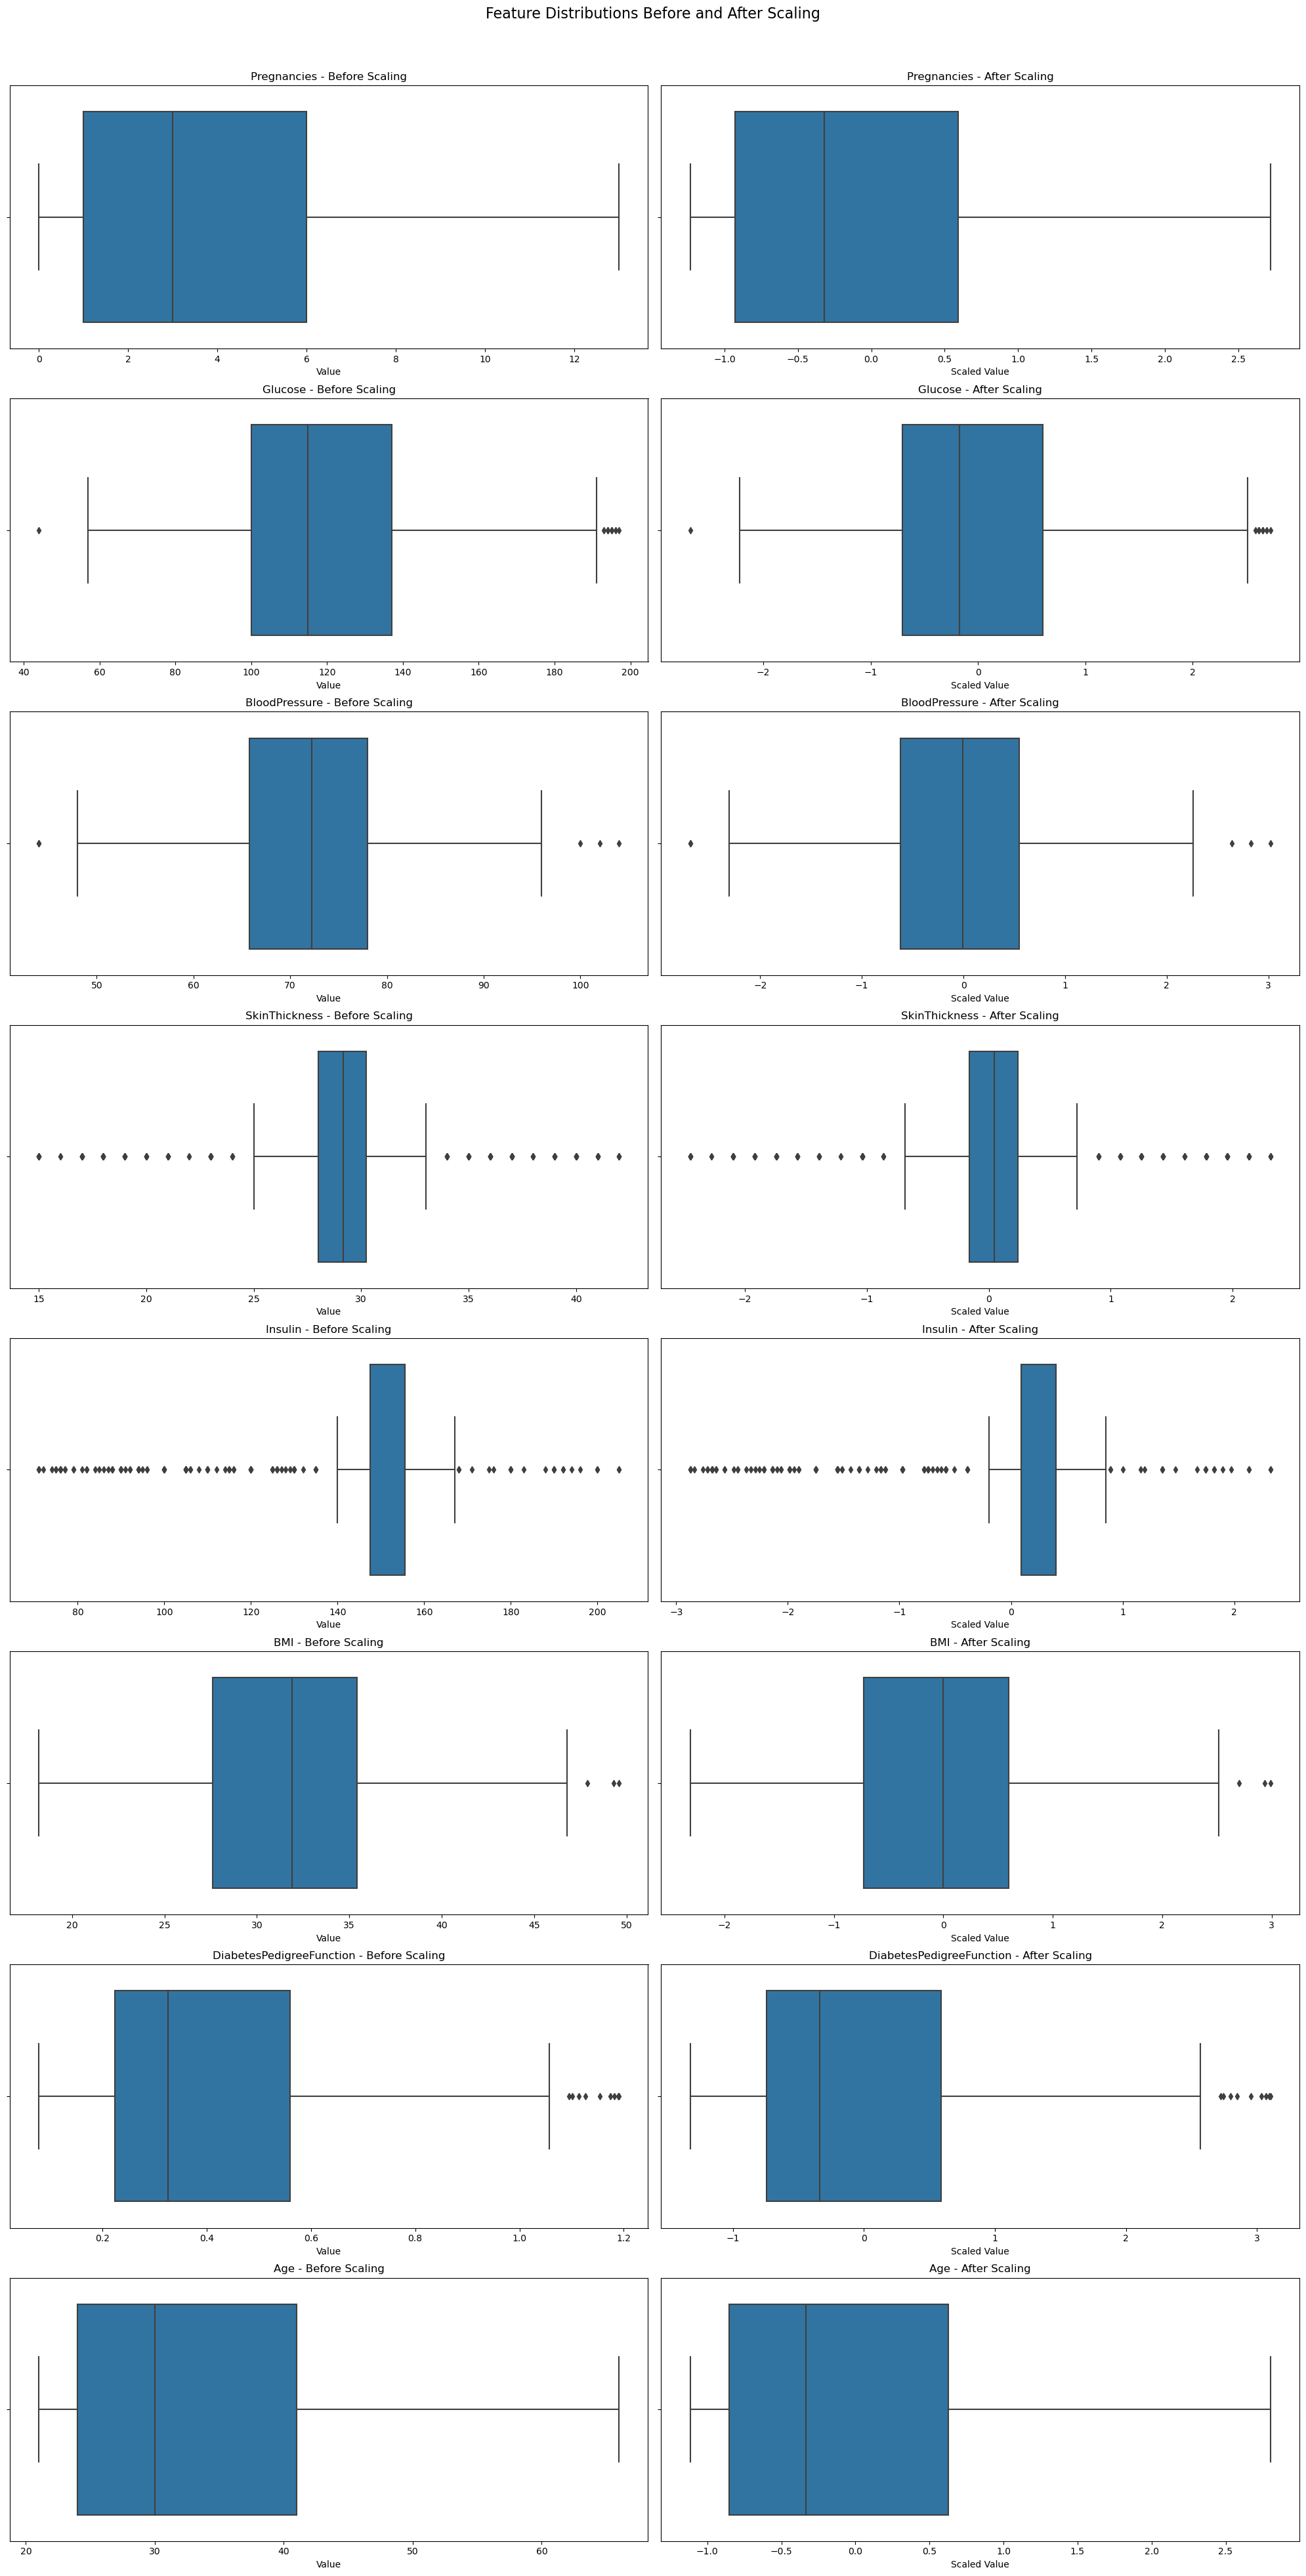

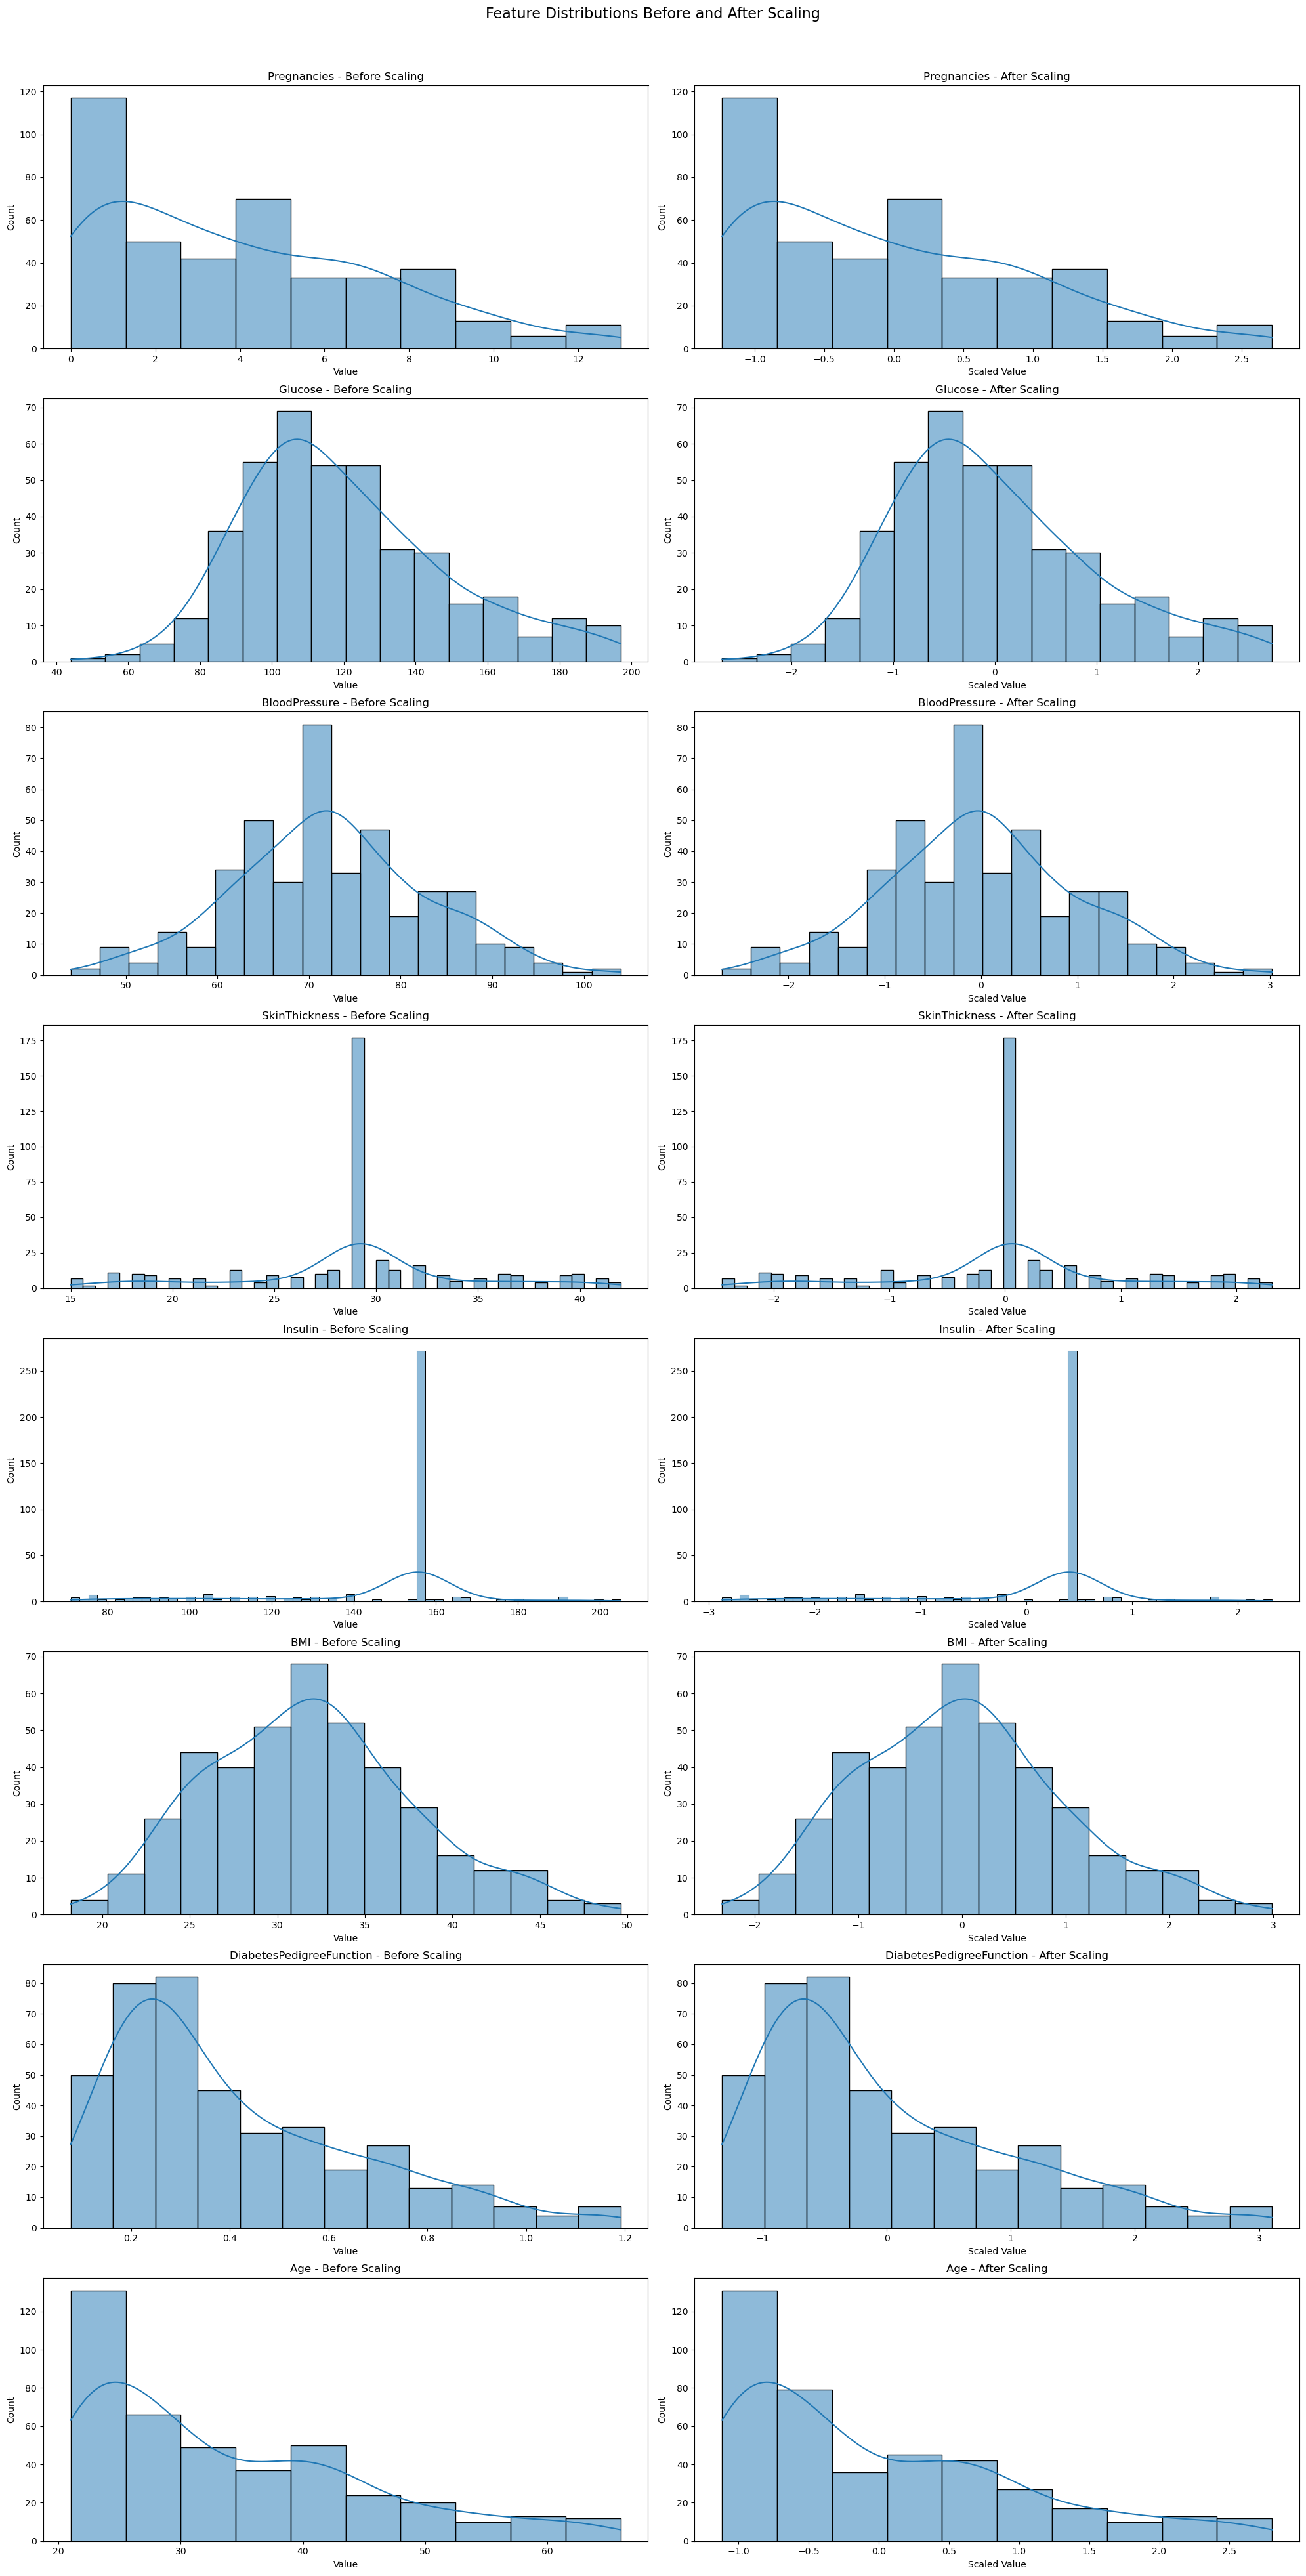

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are already defined from previous steps

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled data summary:")
print(pd.DataFrame(X_train_scaled, columns=X.columns).describe())

# Visualize each feature before and after scaling
n_features = X_train.shape[1]
fig, axes = plt.subplots(n_features, 2, figsize=(20, 5*n_features))
fig.suptitle('Feature Distributions Before and After Scaling', fontsize=16)

for i, feature in enumerate(X.columns):
    # Before scaling
    sns.boxplot(x=X_train[feature], ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} - Before Scaling')
    axes[i, 0].set_xlabel('Value')
    
    # After scaling
    sns.boxplot(x=X_train_scaled[:, i], ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - After Scaling')
    axes[i, 1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Visualize distributions before and after scaling
fig, axes = plt.subplots(n_features, 2, figsize=(20, 5*n_features))
fig.suptitle('Feature Distributions Before and After Scaling', fontsize=16)

for i, feature in enumerate(X.columns):
    # Before scaling
    sns.histplot(X_train[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} - Before Scaling')
    axes[i, 0].set_xlabel('Value')
    
    # After scaling
    sns.histplot(X_train_scaled[:, i], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - After Scaling')
    axes[i, 1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Step-4 Apply PCA

Number of components: 8
Explained variance ratio: [0.26372111 0.17776591 0.12878028 0.1145347  0.10755125 0.08944408
 0.06478094 0.05342175]


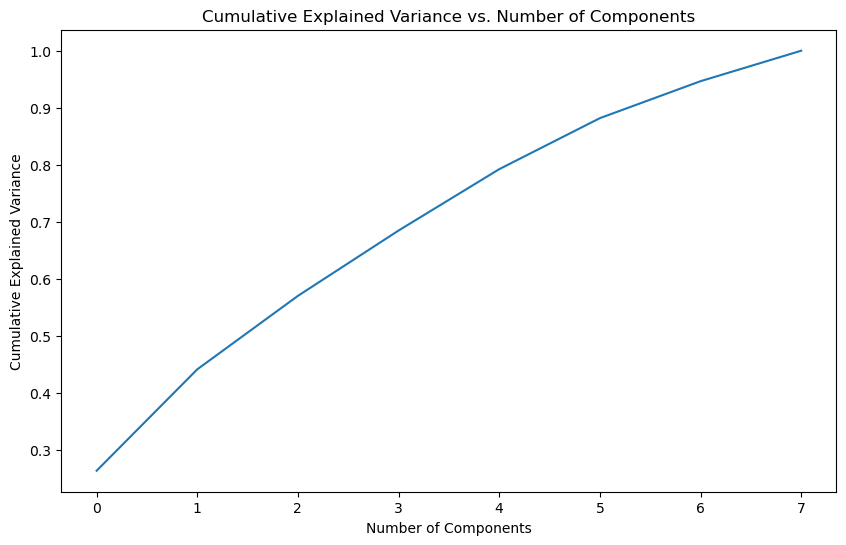

In [90]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Number of components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

## Step 5: Train and Evaluate the MLP Model

Accuracy: 0.7282
Sensitivity: 0.6250
Specificity: 0.7937
ROC AUC: 0.7873


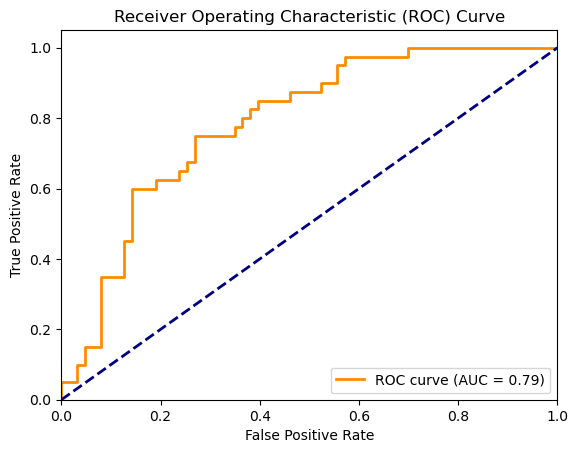

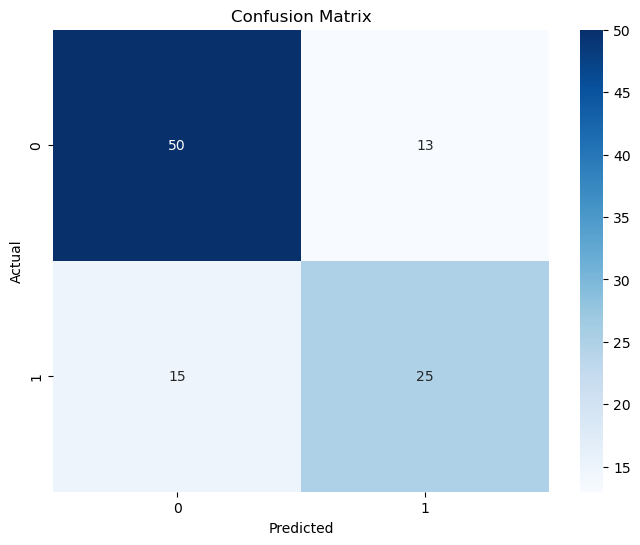

In [91]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Define MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)

# Train the model
mlp.fit(X_train_pca, y_train)

# Make predictions
y_pred = mlp.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC curve
y_pred_proba = mlp.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Step 6: Learning Curve

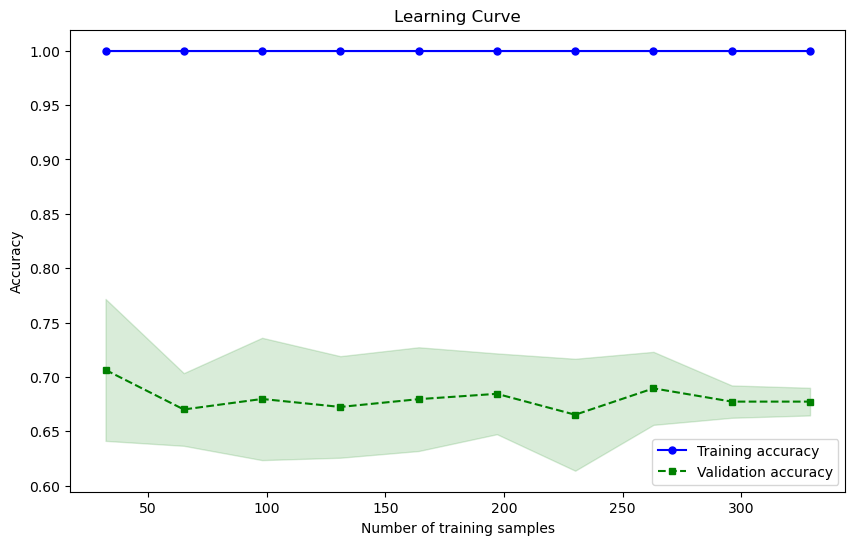

In [92]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    mlp, X_train_pca, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.show()

## Comparing MLP with other models 


Model Comparison:
------------------------------------------------------------
Model                Accuracy   Sensitivity Specificity ROC AUC   
------------------------------------------------------------
Perceptron           0.6796     0.5750     0.7460     0.6605    
MLP                  0.7282     0.6250     0.7937     0.7873    
Logistic Regression  0.7476     0.4500     0.9365     0.8452    
Decision Tree        0.7476     0.5750     0.8571     0.7161    
Random Forest        0.7184     0.5000     0.8571     0.8456    
SVM                  0.7573     0.5000     0.9206     0.8417    
KNN                  0.7282     0.6000     0.8095     0.8109    


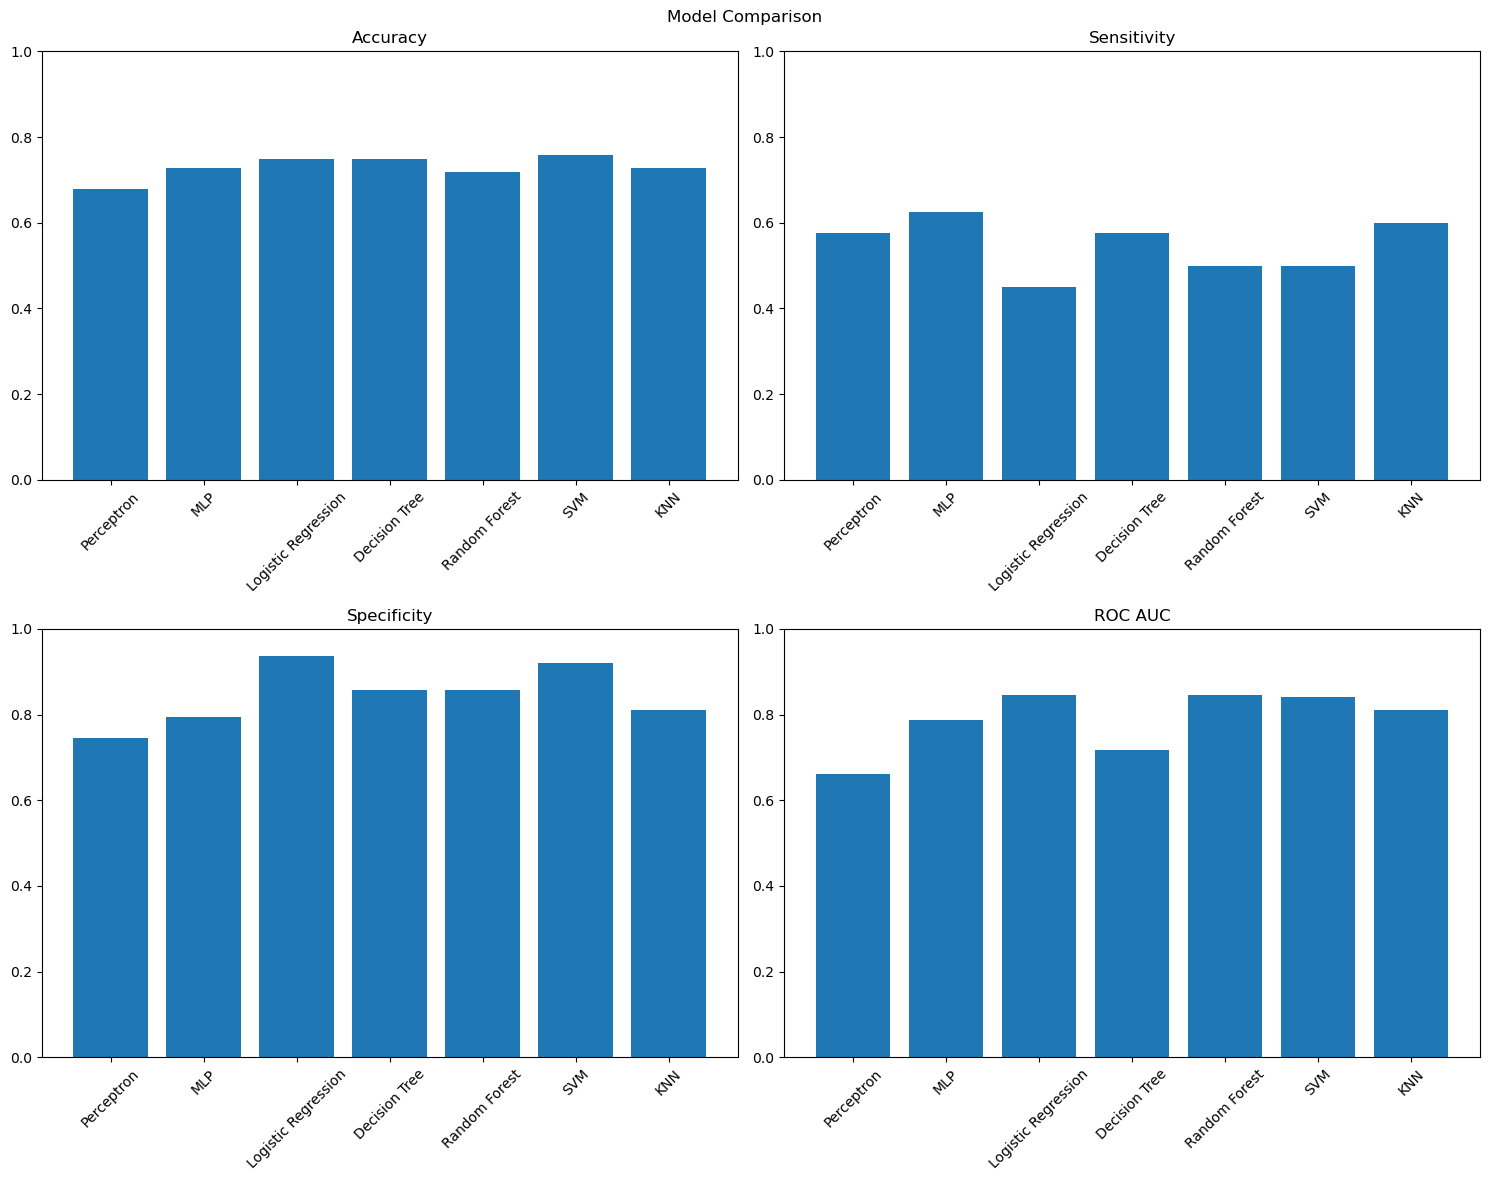


Cross-validation Results:
------------------------------------------------------------
Model                Mean       Std       
------------------------------------------------------------
Perceptron           0.6649     0.0647    
MLP                  0.6846     0.0214    
Logistic Regression  0.7646     0.0289    
Decision Tree        0.6457     0.0487    
Random Forest        0.7525     0.0437    
SVM                  0.7524     0.0241    
KNN                  0.7183     0.0433    


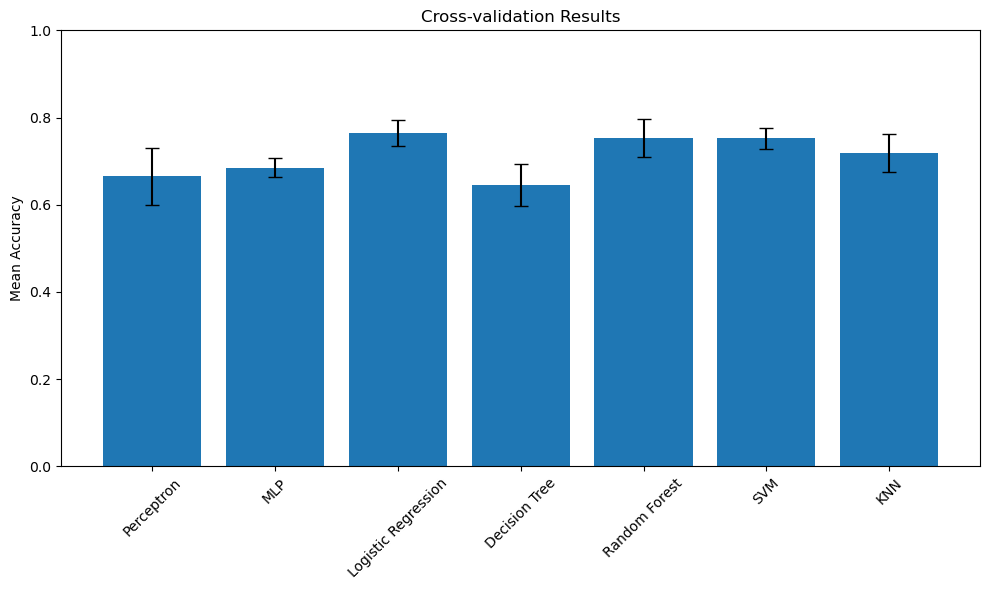

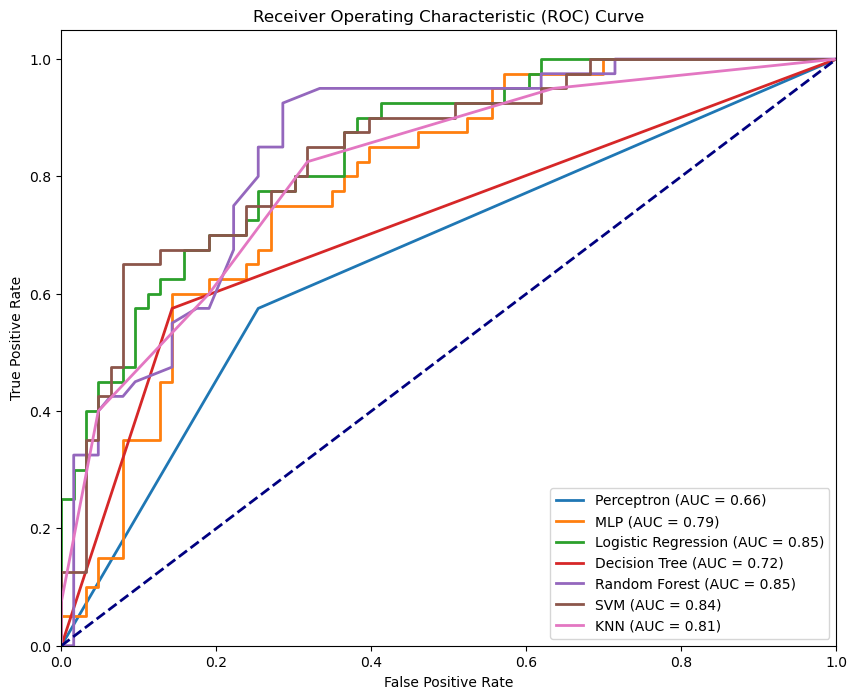

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Assuming X and y are already defined and preprocessed from previous steps

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define models
models = {
    'Perceptron': Perceptron(learning_rate=0.01, n_iterations=1000),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    results[name] = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'ROC AUC': roc_auc
    }

# Print results
print("\nModel Comparison:")
print("------------------------------------------------------------")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Sensitivity", "Specificity", "ROC AUC"))
print("------------------------------------------------------------")
for model, metrics in results.items():
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        model, metrics['Accuracy'], metrics['Sensitivity'], metrics['Specificity'], metrics['ROC AUC']))

# Visualize results
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'ROC AUC']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison')

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    values = [results[model][metric] for model in models]
    ax.bar(models.keys(), values)
    ax.set_title(metric)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Perform cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_pca, y_train, cv=5)
    cv_results[name] = {
        'Mean': scores.mean(),
        'Std': scores.std()
    }

print("\nCross-validation Results:")
print("------------------------------------------------------------")
print("{:<20} {:<10} {:<10}".format("Model", "Mean", "Std"))
print("------------------------------------------------------------")
for model, metrics in cv_results.items():
    print("{:<20} {:<10.4f} {:<10.4f}".format(model, metrics['Mean'], metrics['Std']))

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
means = [metrics['Mean'] for metrics in cv_results.values()]
stds = [metrics['Std'] for metrics in cv_results.values()]
plt.bar(models.keys(), means, yerr=stds, capsize=5)
plt.title('Cross-validation Results')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ROC curves for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test_pca)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()